In [3]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [4]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from transformers import AutoTokenizer, TFBertModel

In [5]:
# load dataset
# dataset from https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
dataset = pd.read_csv('stock_data.csv')
dataset.loc[dataset['Sentiment'] == -1, 'Sentiment'] = 0
dataset.shape

(5791, 2)

In [6]:
dataset.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [7]:
def convert_to_american(token):
    # Copied from here
    token = re.sub(r"(...)our$", r"\1or", token)
    token = re.sub(r"([bt])re$", r"\1er", token)
    token = re.sub(r"([iy])s(e$|ing|ation)", r"\1z\2", token)
    token = re.sub(r"ogue$", "og", token)
    return token
        
def preprocessing(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') for t in tokens]
    
    # 4. Convert British spelling to American spelling (this won't convert 100%)
    tokens = [convert_to_american(t) for t in tokens]

    # 5. Remove stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['cannot', 'could', 'done', 'let', 'may' 'mayn',  'might',  'must', 'need', 'ought', 'oughtn', 
                       'shall', 'would', 'br'])
    tokens = [t for t in tokens if t not in stop_words]
    tokens = " ".join(tokens)
    return tokens

In [8]:
# pre-processing
dataset = dataset.dropna(subset=["Text"])
sentences = []
length_words = []
max_length = 0
for index, row in dataset.iterrows():
    sentence = row['Text']
    sentence = sentence.lower()
    if(max_length < len(sentence)):
      max_length = len(sentence)
    sentence = preprocessing(sentence)
    sentences.append(sentence)
    length_words.append(len(sentence))

dataset['Text_Prep'] = sentences
dataset['Length_Words'] = length_words
print(max_length)

154


In [9]:
print(len(dataset.loc[dataset['Length_Words'] <= 100]) / len(dataset))

0.9633914695216715


In [ ]:
histogram = dataset['Length_Words'].plot.hist()
print(histogram)
plt.show()

In [10]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(dataset['Text_Prep'],dataset['Sentiment'],stratify=dataset['Sentiment'],test_size=0.20)

(4632, 2)


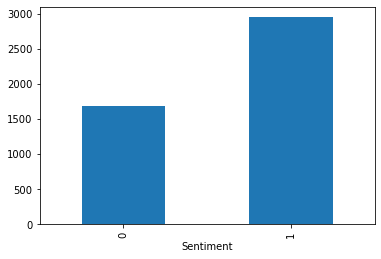

In [11]:
df_train = pd.DataFrame(list(zip(X_train, y_train)), columns=['Text_Prep', 'Sentiment'])
df_train.groupby(['Sentiment']).size().plot(kind='bar')
print(df_train.shape)

(1159, 2)


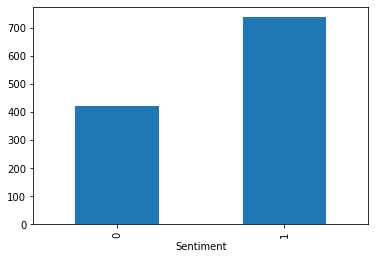

In [12]:
df_test = pd.DataFrame(list(zip(X_test, y_test)), columns=['Text_Prep', 'Sentiment'])
df_test.groupby(['Sentiment']).size().plot(kind='bar')
print(df_test.shape)

In [13]:
y_train = tf.keras.utils.to_categorical(df_train['Sentiment'])
y_test = tf.keras.utils.to_categorical(df_test['Sentiment'])

In [14]:
# load pre-trained model BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

# tokenizing
max_len = 100 # from histogram length words
x_train = tokenizer(text=df_train['Text_Prep'].tolist(),
                    add_special_tokens=True,
                    max_length=max_len,
                    truncation=True,
                    padding='max_length',
                    return_tensors='tf',
                    return_token_type_ids=False,
                    return_attention_mask=True,
                    verbose=True)
x_test = tokenizer(text=df_test['Text_Prep'].tolist(),
                   add_special_tokens=True,
                   max_length=max_len,
                   truncation=True,
                   padding='max_length',
                   return_tensors='tf',
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
# build model fine tuning bert
input_ids = tf.keras.layers.Input(
    shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(
    shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(32, activation='relu')(out)
y = tf.keras.layers.Dense(2, activation='softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = tf.keras.optimizers.Adam(
    # this learning rate is for bert model , taken from huggingface website
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

In [16]:
# model training
history = model.fit(
    x={'input_ids': x_train['input_ids'],
        'attention_mask': x_train['attention_mask']},
    y=y_train,
    validation_data=(
        {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, y_test),
    epochs=2,
    batch_size=32
)

Epoch 1/2


2023-02-09 07:57:58.504531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


145/145 [==============================] - 124s 714ms/step - loss: 0.5994 - balanced_accuracy: 0.6775 - val_loss: 0.5026 - val_balanced_accuracy: 0.7575
Epoch 2/2
145/145 [==============================] - 103s 710ms/step - loss: 0.4370 - balanced_accuracy: 0.8012 - val_loss: 0.4799 - val_balanced_accuracy: 0.7748


In [17]:
# prediction
predicted_raw = model.predict(
    {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

y_predicted = np.argmax(predicted_raw, axis=1)
y_true = df_test['Sentiment']

print(classification_report(y_true, y_predicted, target_names=['NEGATIVE', 'POSITIVE']))

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.57      0.65       421
    POSITIVE       0.78      0.89      0.83       738

    accuracy                           0.77      1159
   macro avg       0.77      0.73      0.74      1159
weighted avg       0.77      0.77      0.77      1159

